# Group 19: HR data
## Planning Stage
### Nolan Vibhakar

In [ ]:
#install cowplot package for later use
install.packages("cowplot")

In [18]:
#Read in libraries
library(broom)
library(repr)
library(ggplot2)
library(gridExtra)
library(cowplot)
library(glmnet)
library(modelr)
library(tidyverse)


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [3]:
#Load data from web
HR_data <- read_csv("https://raw.githubusercontent.com/mnvibhakar/STAT301_project/main/HR-Employee-Attrition.csv")
head(HR_data)
#get list of variables in the data set, and set the column names to the names of the variables
colnames(HR_data) <- make.names(colnames(HR_data))
colnames(HR_data)

Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
dbl (26): Age, DailyRate, DistanceFromHome, Education, EmployeeCount, Employ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


[1] "Age"                      "Attrition"               
 [3] "BusinessTravel"           "DailyRate"               
 [5] "Department"               "DistanceFromHome"        
 [7] "Education"                "EducationField"          
 [9] "EmployeeCount"            "EmployeeNumber"          
[11] "EnvironmentSatisfaction"  "Gender"                  
[13] "HourlyRate"               "JobInvolvement"          
[15] "JobLevel"                 "JobRole"                 
[17] "JobSatisfaction"          "MaritalStatus"           
[19] "MonthlyIncome"            "MonthlyRate"             
[21] "NumCompaniesWorked"       "Over18"                  
[23] "OverTime"                 "PercentSalaryHike"       
[25] "PerformanceRating"        "RelationshipSatisfaction"
[27] "StandardHours"            "StockOptionLevel"        
[29] "TotalWorkingYears"        "TrainingTimesLastYear"   
[31] "WorkLifeBalance"          "YearsAtCompany"          
[33] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[35] "YearsWithCurrManager"

### Dataset Summary
The data set involves information collected by an HR department about employees at their company. The intention behind the collection was to determine what could be done, if anything, to retain employees and prevent attrition. In total, there are 1470 observations, with 35 variables, including
* Attrition: Whether the employee left or not
* Age (of the employee)
* BusinessTravel: categorical variable of how often the employee travels for business
* DailyRate: the amount in dollars that the employee makes per day
* Department: categorical variable of the department the employee works in
* DistanceFromHome: distance in km from the employees home to work
* Education: The education level of the employee, from 1-5
* EducationField: categorical variable of the field the employee was educatied in
* EmployeeCount: The number of employees described by the observation
* EmployeeNumber: the number of the employee
* EnvironmentSatisfaction: rated on a scale of 1-4
* Gender: categorical variable of the employee's gender
* HourlyRate: in dollars
* JobInvolvement: scale from 1-4
* JobLevel: scale of 1-4
* JobRole: categorical variable of the Job role
* JobSatisfaction: scale of 1-4
* MaritalStatus: categorical variable of marital status
* MonthlyIncome: in dollars
* MonthlyRate: in dollars
* NumCompaniesWorked: number of companies worked for over lifetime
* Over18: true/false
* OverTime: true'false of whether the employee works overtime
* PercentSalaryHike: percentage of salary hike
* PerformanceRating: Scale of 3 or 4
* Relationship Satisfaction: on a scale from 1-4
* Standard hours: standard weekly hours
* StockOptionLevel: on a scale from 1-3
* TotalWorkingYears: number of years worked over lifetime
* TrainingTimesLastYear: number of hours spent in training
* WorkLifeBalance: On a scale from 1-4
* YearsAtCompany: years at current company
* YearsInCurrentRole
* YearsSinceLastPromotion
* YearsWithCurrManager

### Data Exploration and Question
The main question we are trying to answer is how to better retain employees. In essence, given an employee, can we predict if they are likely to leave, so that preventive measures can be taken before they do so. Our response variable will therefore be `Attrition` as it describes whether an employee left or not. However, there are many variables we could consider as covariates. So the first step is to determine which variables have the biggest impact on attrition, and therefore which to include in our model. There are a number of redundant columns in which all the observations have the same value, such as `Over18`, `StandardHours`, and `EmployeeCount`. Even eliminating those columns, there are still a large number of covariates. To further narrow down which input covariates to select for our model, we will analyze the correlation between variables, as well as do some background research.

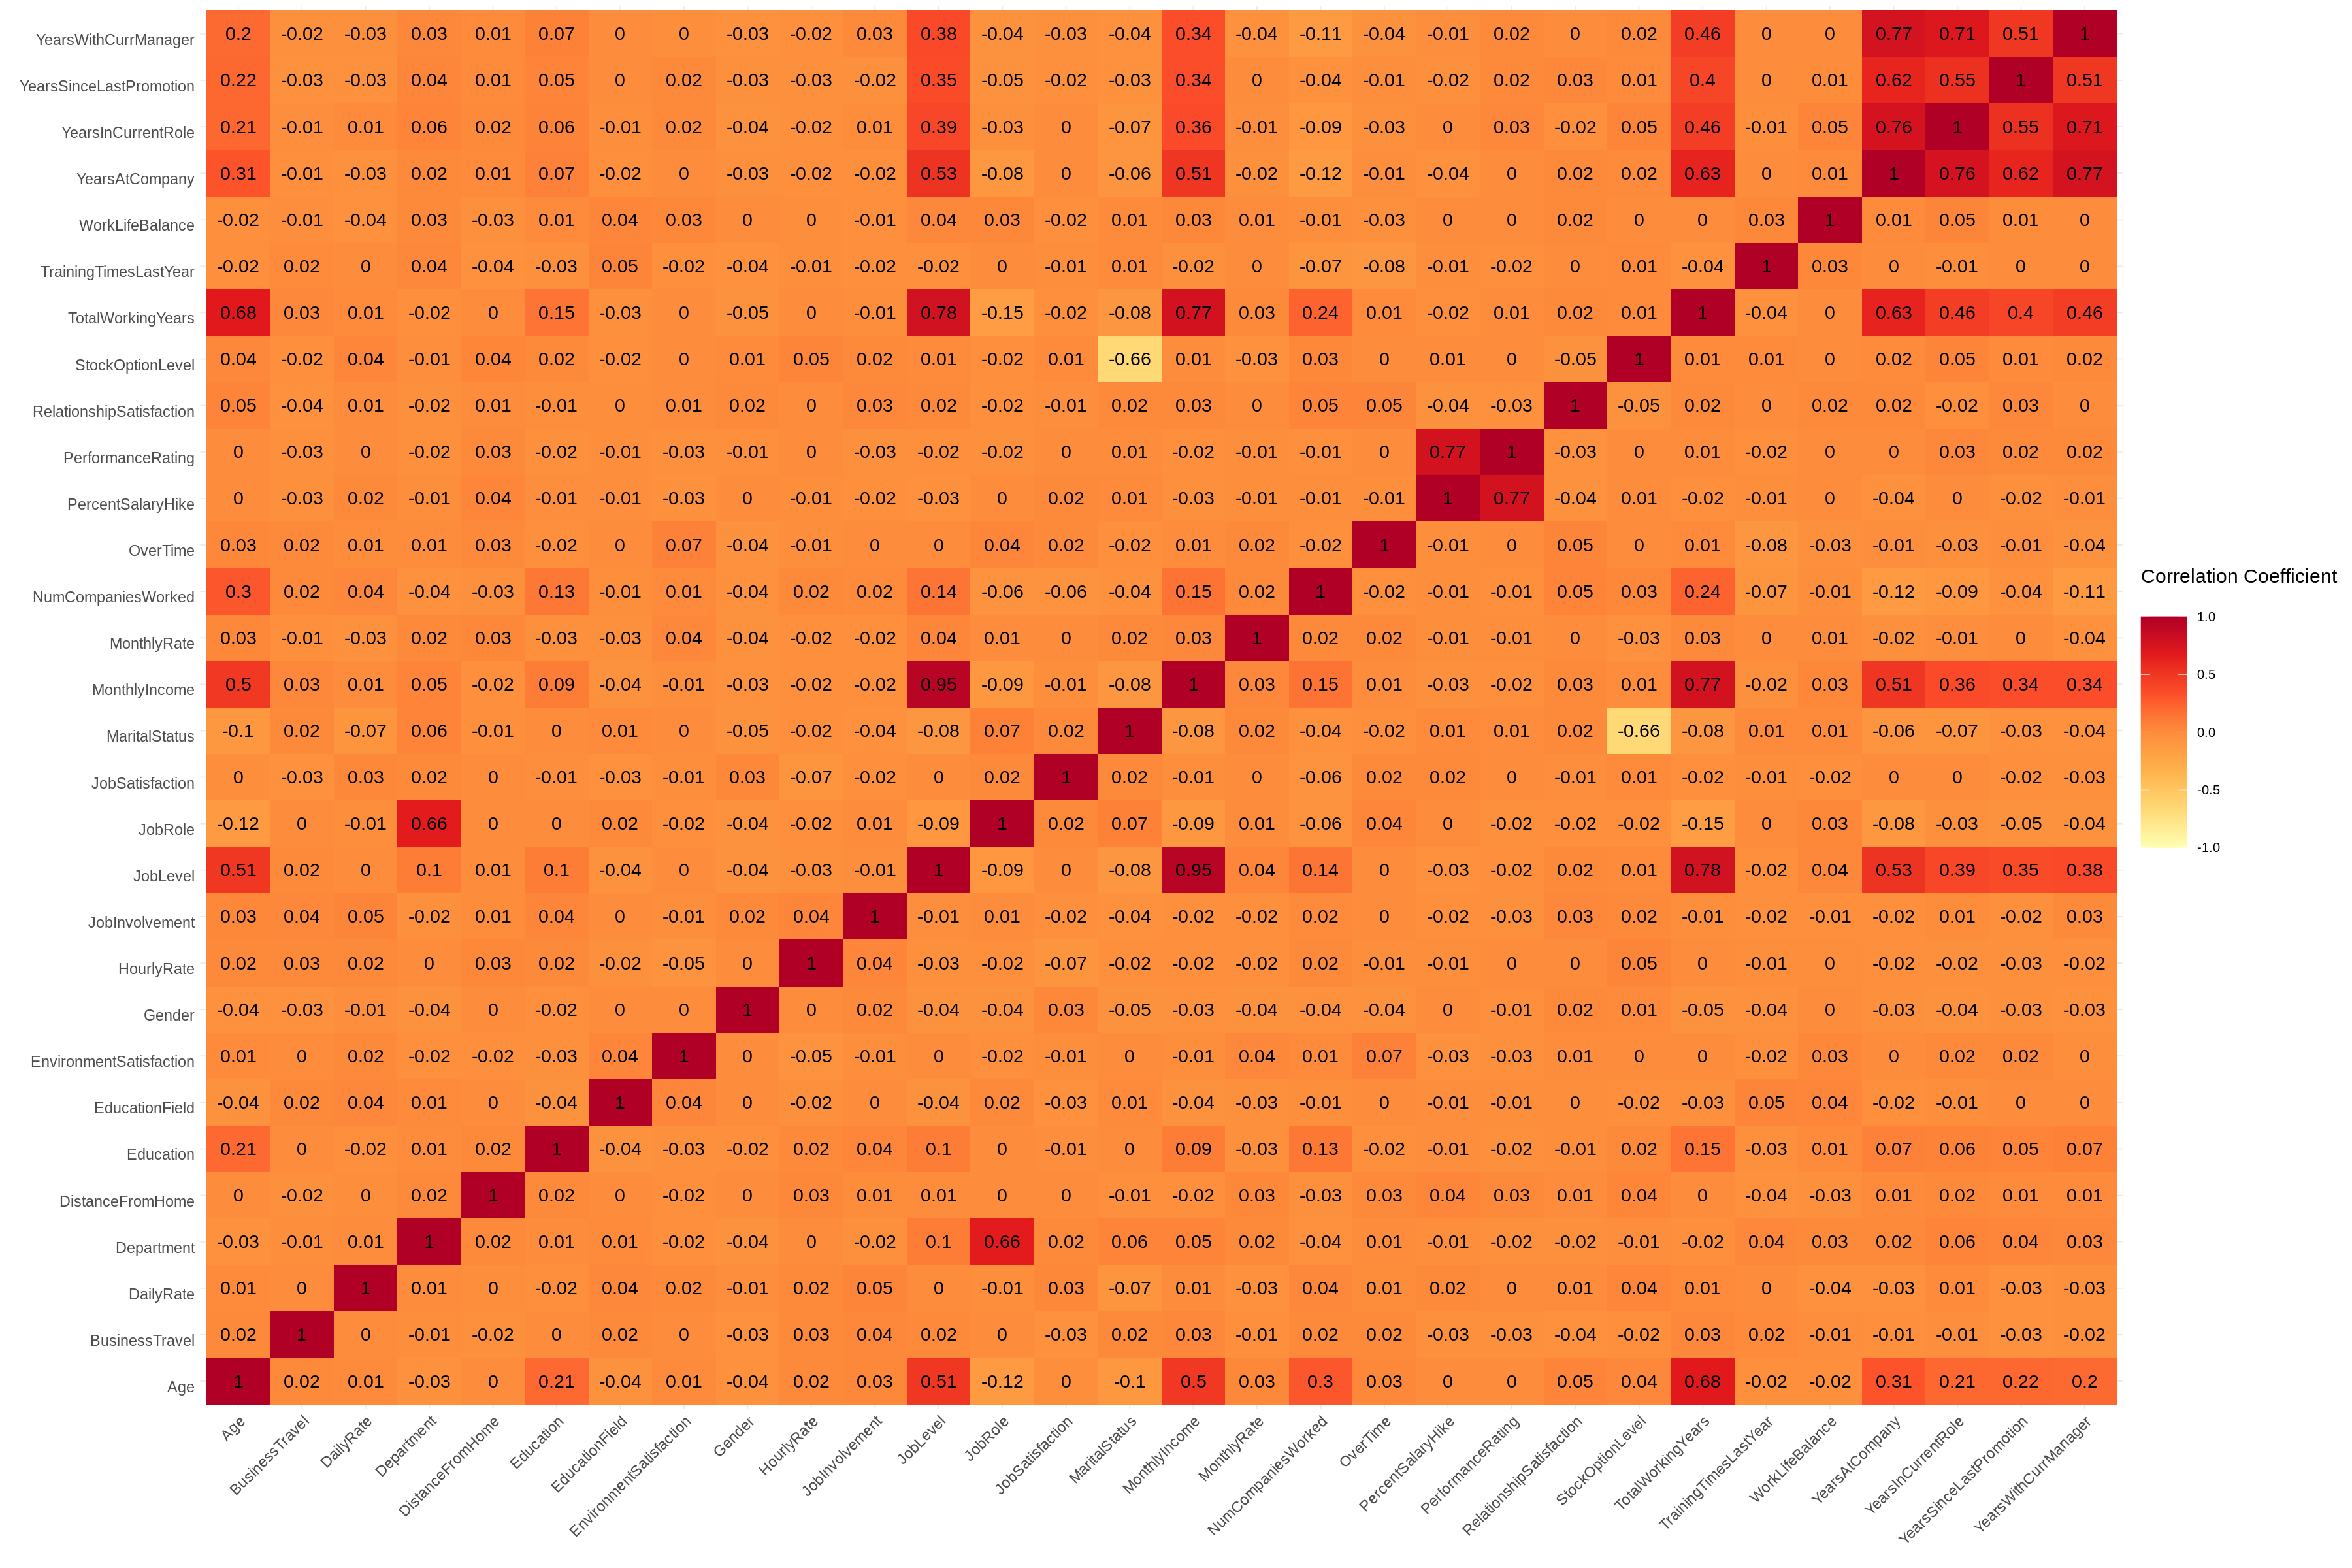

In [4]:
#remove columns with only one variable across all observations, as well as EmployeeNumber
HR_data <- HR_data |>
    select(-StandardHours, -Over18, -EmployeeCount, -EmployeeNumber)

#find correlation values for all possible input variables
corr_matrix_HR <- HR_data |>
    select(-Attrition) |>
    filter(na.rm = TRUE) |>
    data.matrix() |>
    cor() |>
    as_tibble(rownames = 'var1') |>
    pivot_longer(-var1, names_to = "var2", values_to = "corr")
#plot heat map of correlation matrix
plot_corr_matrix_HR <- corr_matrix_HR |>
    ggplot(aes(x = var1, y = var2)) +
    geom_tile(aes(fill = corr)) +
    scale_fill_distiller("Correlation Coefficient \n",
      palette =  "YlOrRd",
      direction = 1, 
      limits = c(-1, 1)) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    geom_text(aes(x = var1, y = var2, label = round(corr, 2)), color = "black", size = 6)
options(repr.plot.width = 30, repr.plot.height = 20) 
plot_corr_matrix_HR

In [26]:
#Create table that displays variables with highest overall correlation
corr_matrix_results_HR <- corr_matrix_HR |>
    group_by(var1) |>
    summarize(sum = sum(corr)) |>
    arrange(desc(sum))
corr_matrix_results_HR

var1,sum
<chr>,<dbl>
TotalWorkingYears,5.3076203
JobLevel,5.0207258
MonthlyIncome,4.8607550
YearsAtCompany,4.8161515
YearsInCurrentRole,4.4156374
YearsWithCurrManager,4.1466272
Age,4.0164702
YearsSinceLastPromotion,3.8835439
Department,1.9392794


From our heat map and correlation table, we can see that there are a number of variables that demonstrate multicollinearity. `YearsWithCurrManager`, `YearsInCurrRole`, `YearsAtCompany`, and `YearsSinceLastPromotion` are all highly correlated with eachother, as well as with `JobLevel` and `MonthlyIncome`. We can also see that `TotalWorkingYears` and `Age` also have high correlation values. Considering this, it makes sense to only consider one of these variables as an input for our model. To assess further, we will plot their individual relationships with attrition.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


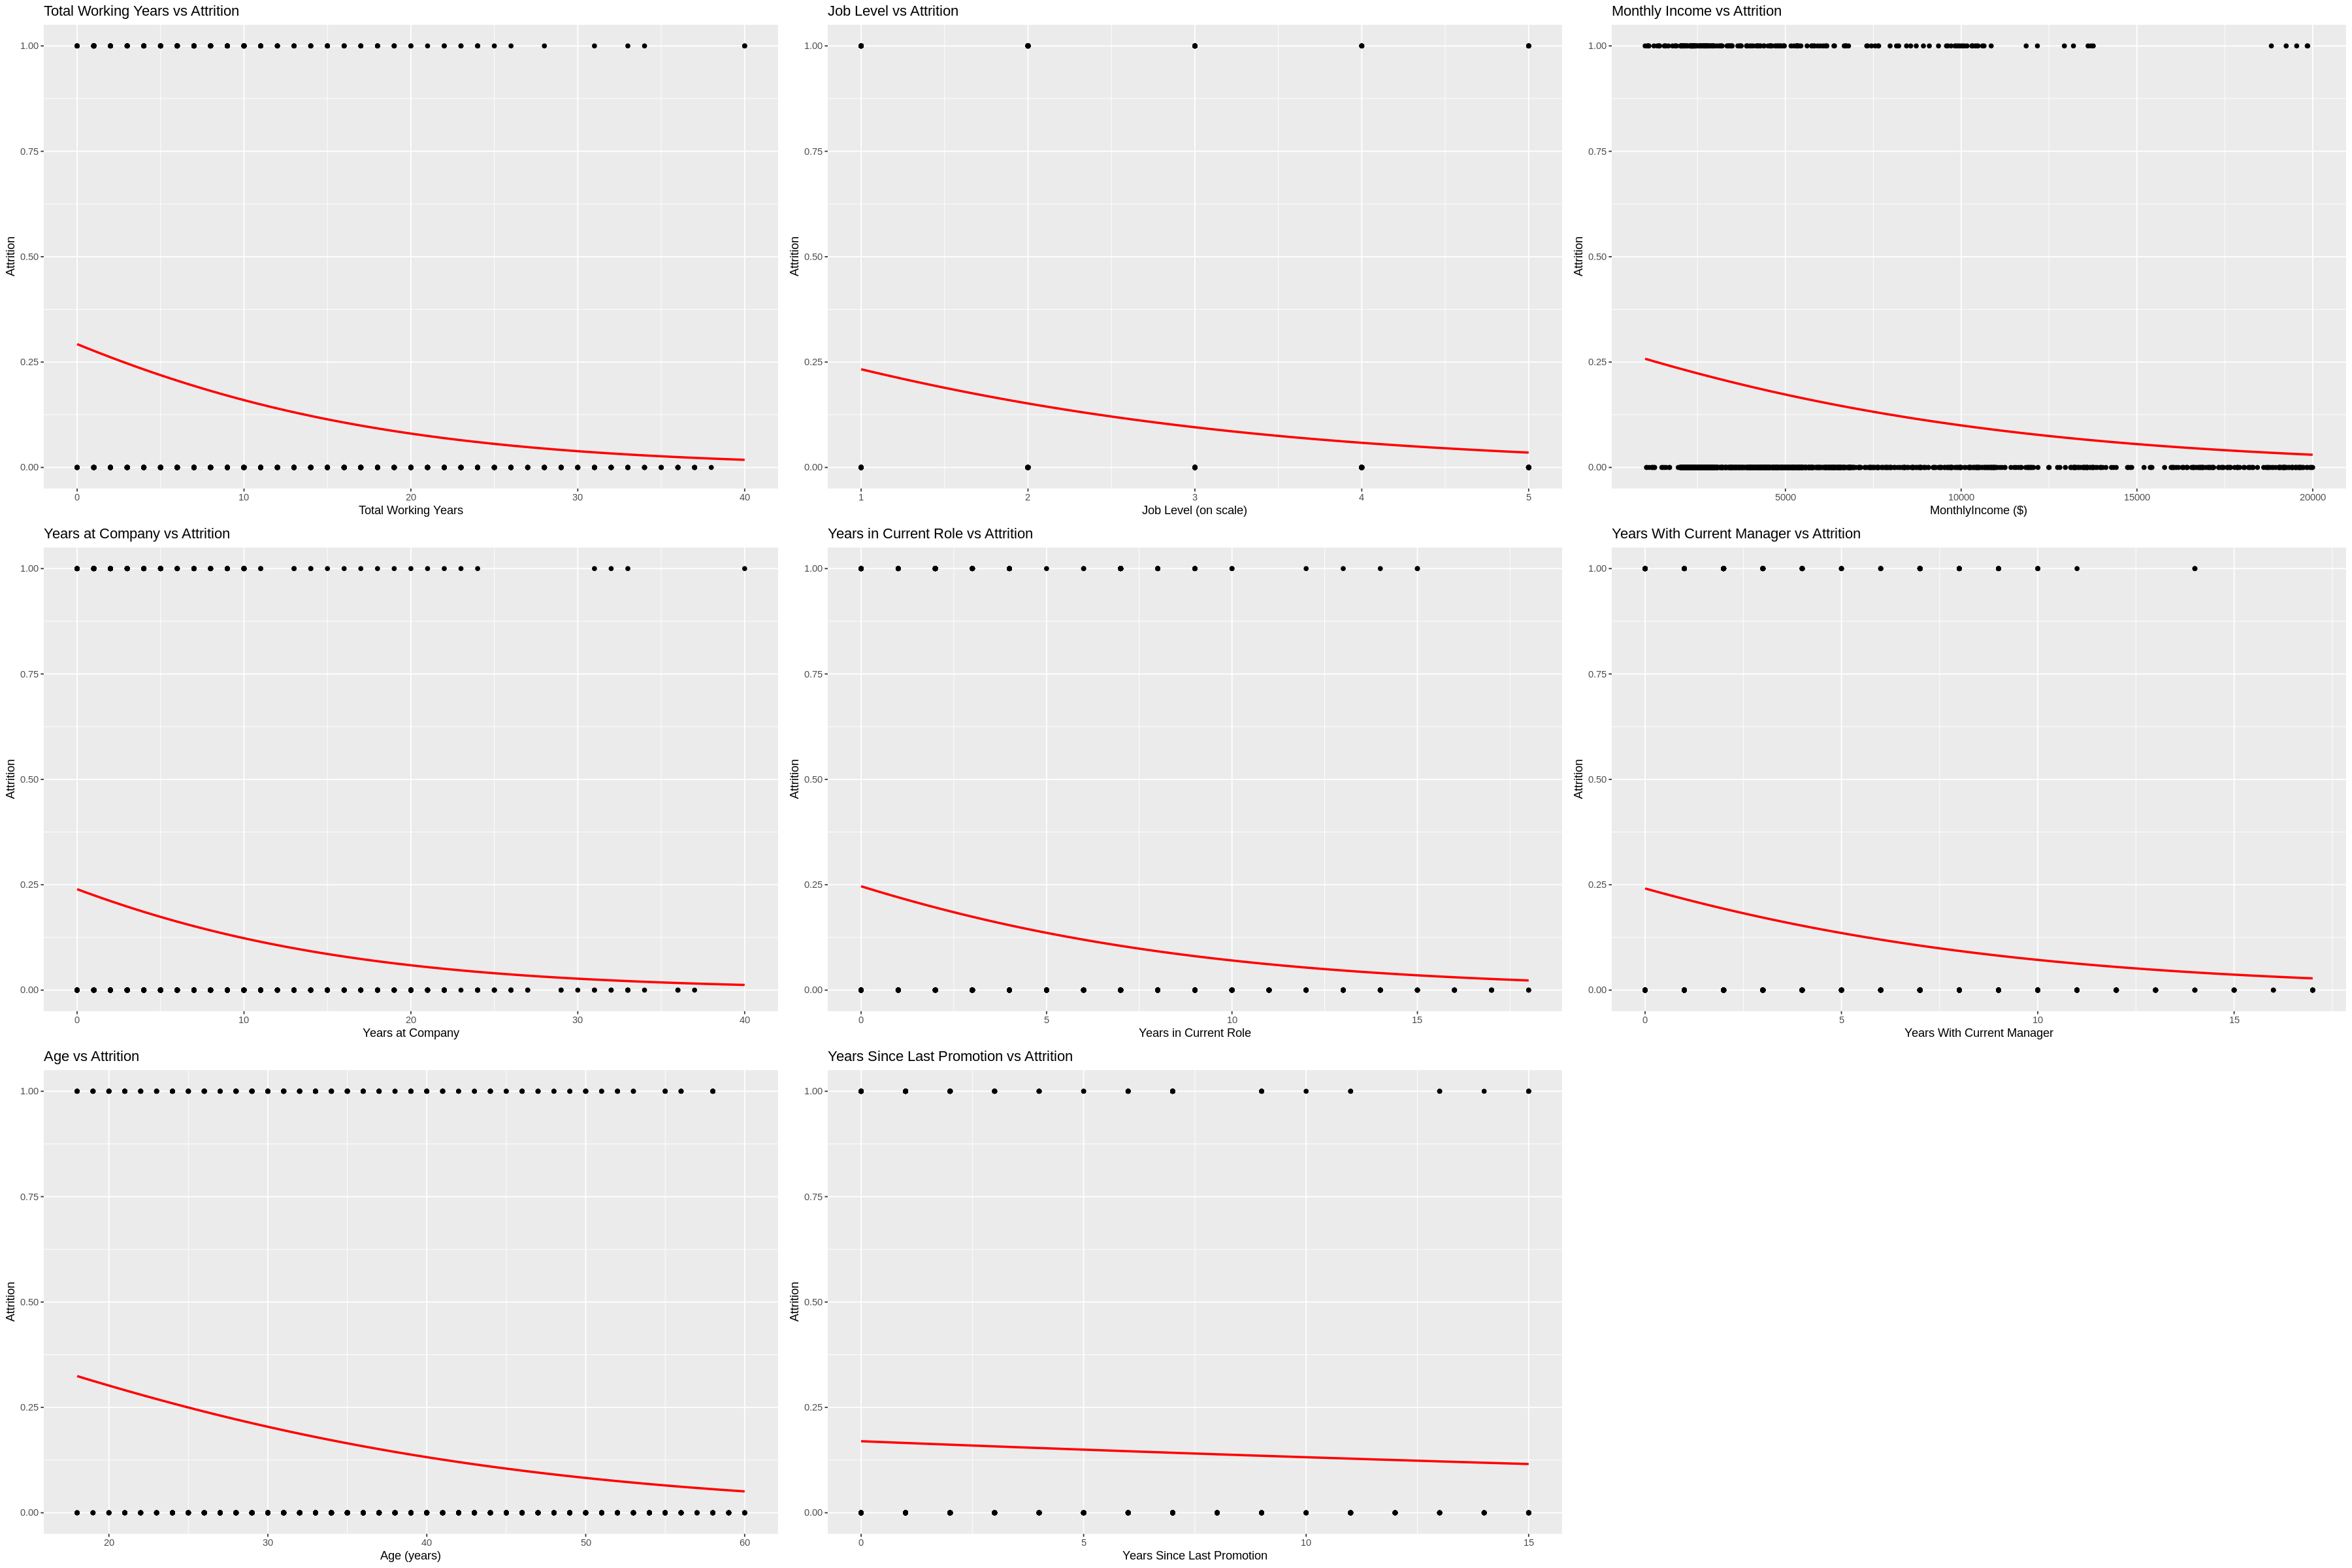

In [27]:
#Adjust Attirtion to be a numerical variable for ease of  plotting
HR_plot_data <- HR_data |> mutate(Attrition = ifelse(Attrition == "Yes", 1, 0))
#create scatterplots with Attirtion on the Y axis and various different variables as the x axis
#fit a logistic curve showing the relationship for each plot
TotalWorkingYears_plot <- HR_plot_data |>
    ggplot(aes(x = TotalWorkingYears, y = Attrition)) +
    geom_point() +
    geom_smooth(aes(x = TotalWorkingYears, y = Attrition),
        method = glm,
        method.args = c(family = binomial), 
        se = FALSE, color = "red") +
    labs(x = "Total Working Years", y = "Attrition", title = "Total Working Years vs Attrition")
JobLevel_plot <- JobLevel <- HR_plot_data |>
    ggplot(aes(x = JobLevel, y = Attrition)) +
    geom_point() +
    geom_smooth(aes(x = JobLevel, y = Attrition),
        method = glm,
        method.args = c(family = binomial), 
        se = FALSE, color = "red") +
    labs(x = "Job Level (on scale)", y = "Attrition", title = "Job Level vs Attrition")
MonthlyIncome_plot <- HR_plot_data |>
    ggplot(aes(x = MonthlyIncome, y = Attrition)) +
    geom_point() +
    geom_smooth(aes(x = MonthlyIncome, y = Attrition),
        method = glm,
        method.args = c(family = binomial), 
        se = FALSE, color = "red") +
    labs(x = "MonthlyIncome ($)", y = "Attrition", title = "Monthly Income vs Attrition")
YearsAtCompany_plot <- HR_plot_data |>
    ggplot(aes(x = YearsAtCompany, y = Attrition)) +
    geom_point() +
    geom_smooth(aes(x = YearsAtCompany, y = Attrition),
        method = glm,
        method.args = c(family = binomial), 
        se = FALSE, color = "red") +
    labs(x = "Years at Company", y = "Attrition", title = "Years at Company vs Attrition")
YearsInCurrentRole_plot <- HR_plot_data |>
    ggplot(aes(x = YearsInCurrentRole, y = Attrition)) +
    geom_point() +
    geom_smooth(aes(x = YearsInCurrentRole, y = Attrition),
        method = glm,
        method.args = c(family = binomial), 
        se = FALSE, color = "red") +
    labs(x = "Years in Current Role", y = "Attrition", title = "Years in Current Role vs Attrition")
YearsWithCurrManager_plot <- HR_plot_data |>
    ggplot(aes(x = YearsWithCurrManager, y = Attrition)) +
    geom_point() +
    geom_smooth(aes(x = YearsWithCurrManager, y = Attrition),
        method = glm,
        method.args = c(family = binomial), 
        se = FALSE, color = "red") +
    labs(x = "Years With Current Manager", y = "Attrition", title = "Years With Current Manager vs Attrition")
Age_plot <- HR_plot_data |>
    ggplot(aes(x = Age, y = Attrition)) +
    geom_point() +
    geom_smooth(aes(x = Age, y = Attrition),
        method = glm,
        method.args = c(family = binomial), 
        se = FALSE, color = "red") +
    labs(x = "Age (years)", y = "Attrition", title = "Age vs Attrition")
YearsSinceLastPromotion_plot <- HR_plot_data |>
    ggplot(aes(x = YearsSinceLastPromotion, y = Attrition)) +
    geom_point() +
    geom_smooth(aes(x = YearsSinceLastPromotion, y = Attrition),
        method = glm,
        method.args = c(family = binomial), 
        se = FALSE, color = "red") +
    labs(x = "Years Since Last Promotion", y = "Attrition", title = "Years Since Last Promotion vs Attrition")
#display plots next to eachother
plot_grid(TotalWorkingYears_plot, JobLevel_plot, MonthlyIncome_plot, YearsAtCompany_plot, YearsInCurrentRole_plot,
          YearsWithCurrManager_plot, Age_plot, YearsSinceLastPromotion_plot)
          

It is clear to see that none of the selected covariates have a strong relation with Attrition, as none of them form a full logistic curve within the given range. This could indicate that a model without any of these covariates would be best.

To further investigate which covariates to select, we conducted some background research. According to the Harvard Business Review (1), the main factors affecting employee retention are job satisfaction and environment. For our model this could include the variables `Department`, `DistanceFromHome`, `EnvironmentSatisfaction`, `JobInvolvement`, `JobSatisfaction`, `MaritalStatus`, `Overtime`, `RelationshipSatisfaction`, and `WorkLifeBalance`. Another study conducted about Sri Lankan Startups also found that Age, Gender, and Managerial Relationship play an important role in turnover (2). With these ideas in mind, we propose a model  with the input variables `DistanceFromHome`, `EnvironmentSatisfaction`, `JobSatisfaction`, `WorkLifeBalance`, `Gender`, and `Age`. Additionally, we will fit models with the same inputs in addition to `Overtime`, `RelationshipSatisfaction`, `Department`, and `YearsWithCurrManager` in various combinations, to assess which factors affect employee retention the most, and to best predict whether an employee will leave so preventitive measures can be taken. 

### Methods
Due to the binary nature of our response variable, we must fit a logistic regression model. Since our problem is also predictive, our first step will be to split the data into a training and testing set so that we can properly assess the performance of our model. Then, we will fit a glm of the binomial family on our training data, using the input variables determined through our data exploration. Additionally, to test our hypotheses from data exploration, we will also use a stepwise forward selection algorithm to fit another model with the inputs determined by the algorithm. To compare our models and also analyze their effectiveness, we will use them to make predictions about our testing set. We will then assess the proportion of true and false positives and negatives of our predictions to determine the best model.

### Citations
1) Flowers, Vincent S, and Charles L Hughes. “Why Employees Stay.” Harvard Business Review, 1 Aug. 2014, hbr.org/1973/07/why-employees-stay. 

2) Kanchana, Lakshmi, and Ruwan Jayathilaka. “Factors Impacting Employee Turnover Intentions among Professionals in Sri Lankan Startups.” PloS One, U.S. National Library of Medicine, 10 Feb. 2023, www.ncbi.nlm.nih.gov/pmc/articles/PMC9916568/. 